
**Load the dependencies**


In [ ]:
pip install csbdeep

In [ ]:
pip install stardist

In [ ]:
from stardist import relabel_image_stardist3D, Rays_GoldenSpiral, calculate_extents
from stardist import fill_label_holes, random_label_cmap
from stardist.matching import matching_dataset

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, download_and_extract_zip_file

In [ ]:
np.random.seed(42)
lbl_cmap = random_label_cmap()

In [ ]:
import skimage as io
from skimage import io
import matplotlib.pyplot as plt
from glob import glob


**Load the training dataset. The dataset consists of 512*512 images, which is memory intensive to train. Instead chop the images into 128*128 and train with them**

In [ ]:
image_list = sorted(glob('/content/drive/MyDrive/stardist_train/images/*.tif'))


In [ ]:
image_list = list(map(io.imread,image_list))


In [ ]:
out_list = []
for i in range(len(image_list)):
    chop_list = [
        image_list[i][:, 0:128, 0:128],
        image_list[i][:, 0:128, 128:256],
        image_list[i][:, 0:128, 256:384],
        image_list[i][:, 0:128, 384:512],
        image_list[i][:, 128:256, 0:128],
        image_list[i][:, 128:256, 128:256],
        image_list[i][:, 128:256, 256:384],
        image_list[i][:, 128:256, 384:512],
        image_list[i][:, 256:384, 0:128],
        image_list[i][:, 256:384, 128:256],
        image_list[i][:, 256:384, 256:384],
        image_list[i][:, 256:384, 384:512],
        image_list[i][:, 384:512, 0:128],
        image_list[i][:, 384:512, 128:256],
        image_list[i][:, 384:512, 256:384],
        image_list[i][:, 384:512, 384:512]
    ]

    out_list.extend(chop_list)

In [ ]:
mask_list = sorted(glob('/content/drive/MyDrive/stardist_train/masks/*.tif'))


In [ ]:
mask_list = list(map(io.imread,mask_list))


In [ ]:
mask_out_list = []
for i in range(len(mask_list)):
    mask_chop_list = [
        mask_list[i][:, 0:128, 0:128],
        mask_list[i][:, 0:128, 128:256],
        mask_list[i][:, 0:128, 256:384],
        mask_list[i][:, 0:128, 384:512],
        mask_list[i][:, 128:256, 0:128],
        mask_list[i][:, 128:256, 128:256],
        mask_list[i][:, 128:256, 256:384],
        mask_list[i][:, 128:256, 384:512],
        mask_list[i][:, 256:384, 0:128],
        mask_list[i][:, 256:384, 128:256],
        mask_list[i][:, 256:384, 256:384],
        mask_list[i][:, 256:384, 384:512],
        mask_list[i][:, 384:512, 0:128],
        mask_list[i][:, 384:512, 128:256],
        mask_list[i][:, 384:512, 256:384],
        mask_list[i][:, 384:512, 384:512]
    ]

    mask_out_list.extend(mask_chop_list)

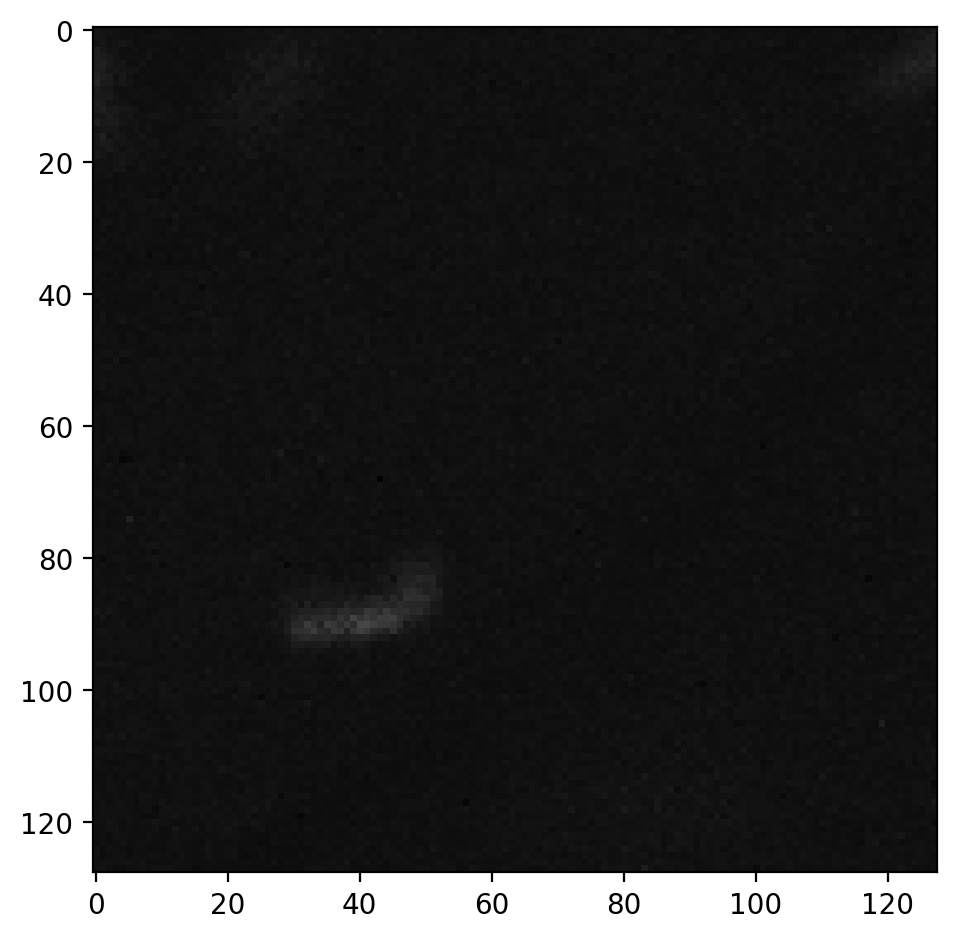

In [ ]:
io.imshow(out_list[1][12,:,:])

matplotlib_plugin.py (150): Low image data range; displaying image with stretched contrast.


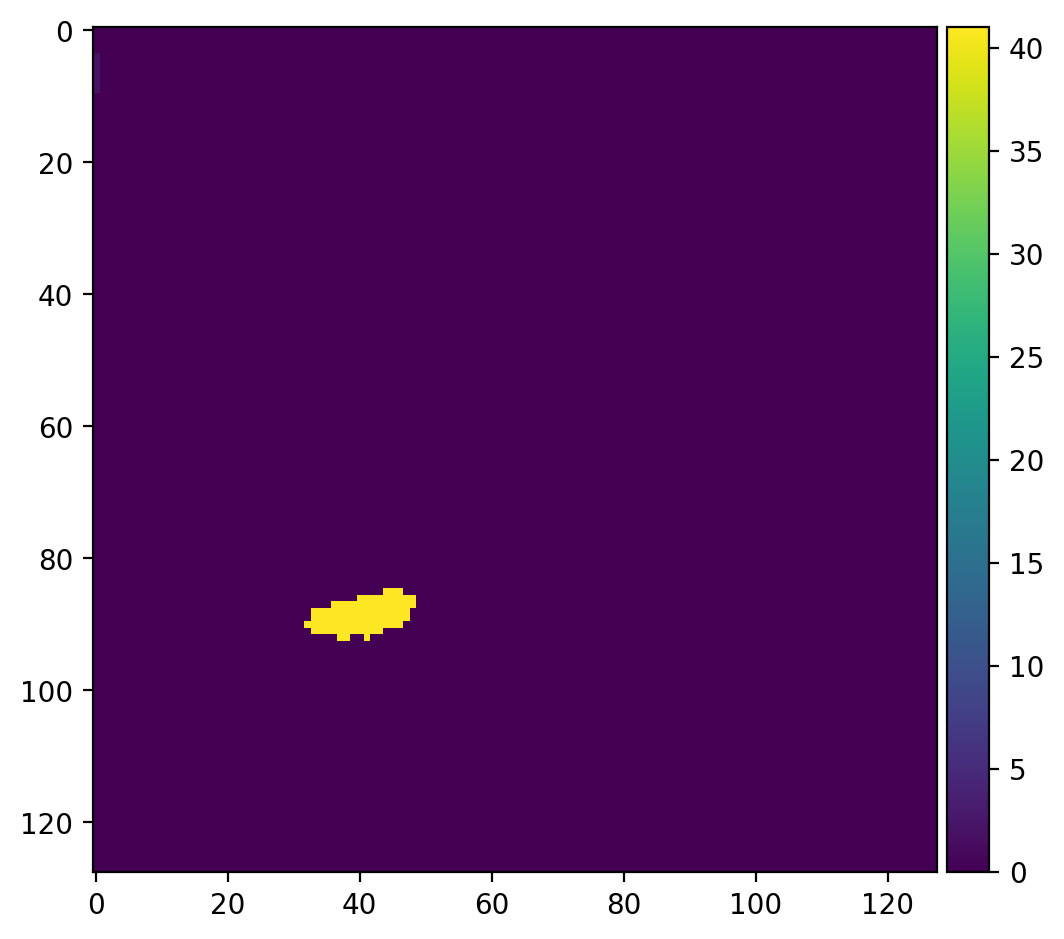

In [ ]:
io.imshow(mask_out_list[1][12,:,:])

In [ ]:
X = out_list
Y = mask_out_list


In [ ]:
i = 0
img, lbl = X[i], fill_label_holes(Y[i])
assert img.ndim in (3,4)
# assumed axes ordering of img and lbl is: ZYX(C)

In [ ]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.087719298245614, 1.1923076923076923, 1.0)


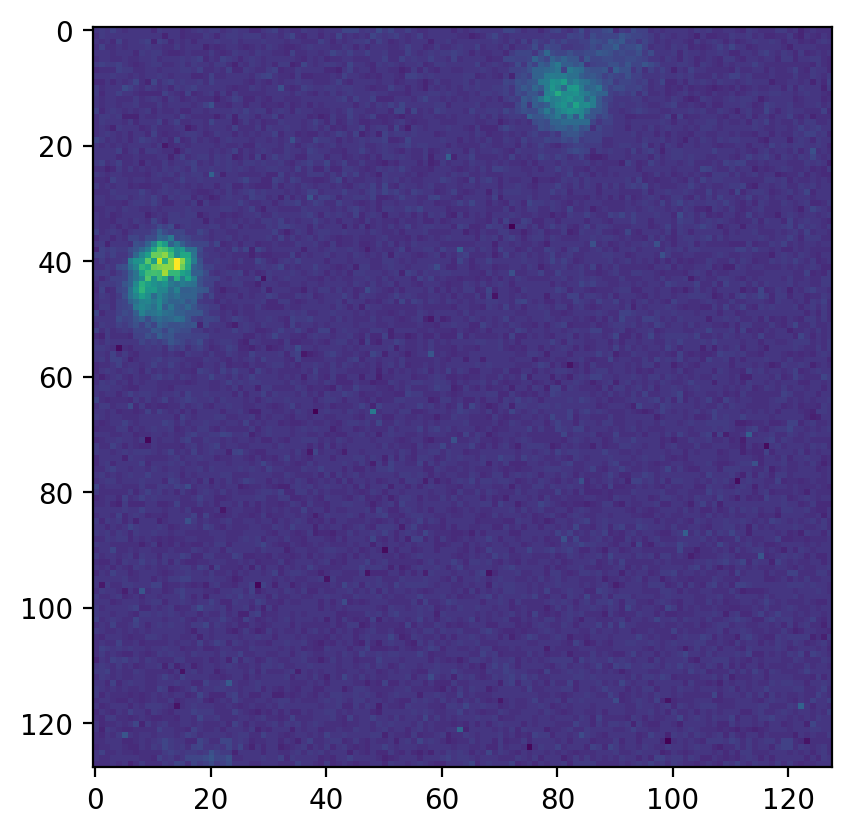

In [ ]:
# randomly try plotting an image and the mask in XY plane
plt.imshow(X[10][12,:,:])

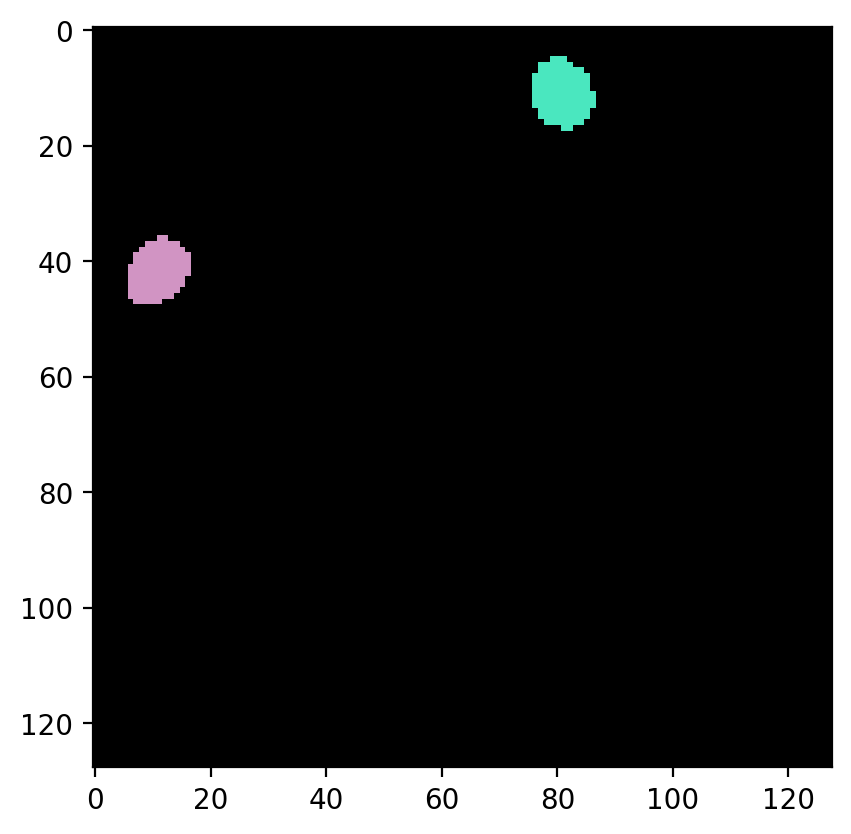

In [ ]:
# Randomly plot a mask in the xy plane
plt.imshow(Y[10][12,:,:], cmap = lbl_cmap)

In [ ]:
# Randomly plot an image in the XZ plane
plt.imshow(X[3][:, 15, :], cmap='gray')


In [ ]:
# Randomly plot an image in the XZ plane
plt.imshow(Y[3][:, 15, :], cmap=lbl_cmap)

In [ ]:
# Randomly plot an image in the YZ plane
plt.imshow(X[3][:,:, 15], cmap='gray')

In [ ]:
# Randomly plot an image in the YZ plane
plt.imshow(Y[3][:,:, 15], cmap=lbl_cmap)

In [ ]:
def reconstruction_scores(n_rays, anisotropy):
    scores = []
    for r in tqdm(n_rays):
        rays = Rays_GoldenSpiral(r, anisotropy=anisotropy)
        Y_reconstructed = [relabel_image_stardist3D(lbl, rays) for lbl in Y]
        mean_iou = matching_dataset(Y, Y_reconstructed, thresh=0, show_progress=False).mean_true_score
        scores.append(mean_iou)
    return scores

In [ ]:
# try different number of rays and see which one produces good output masks.
n_rays = [8, 16, 32, 64]
scores_iso   = reconstruction_scores(n_rays, anisotropy=None)
scores_aniso = reconstruction_scores(n_rays, anisotropy=anisotropy)

100%|██████████| 4/4 [00:49<00:00, 12.41s/it]


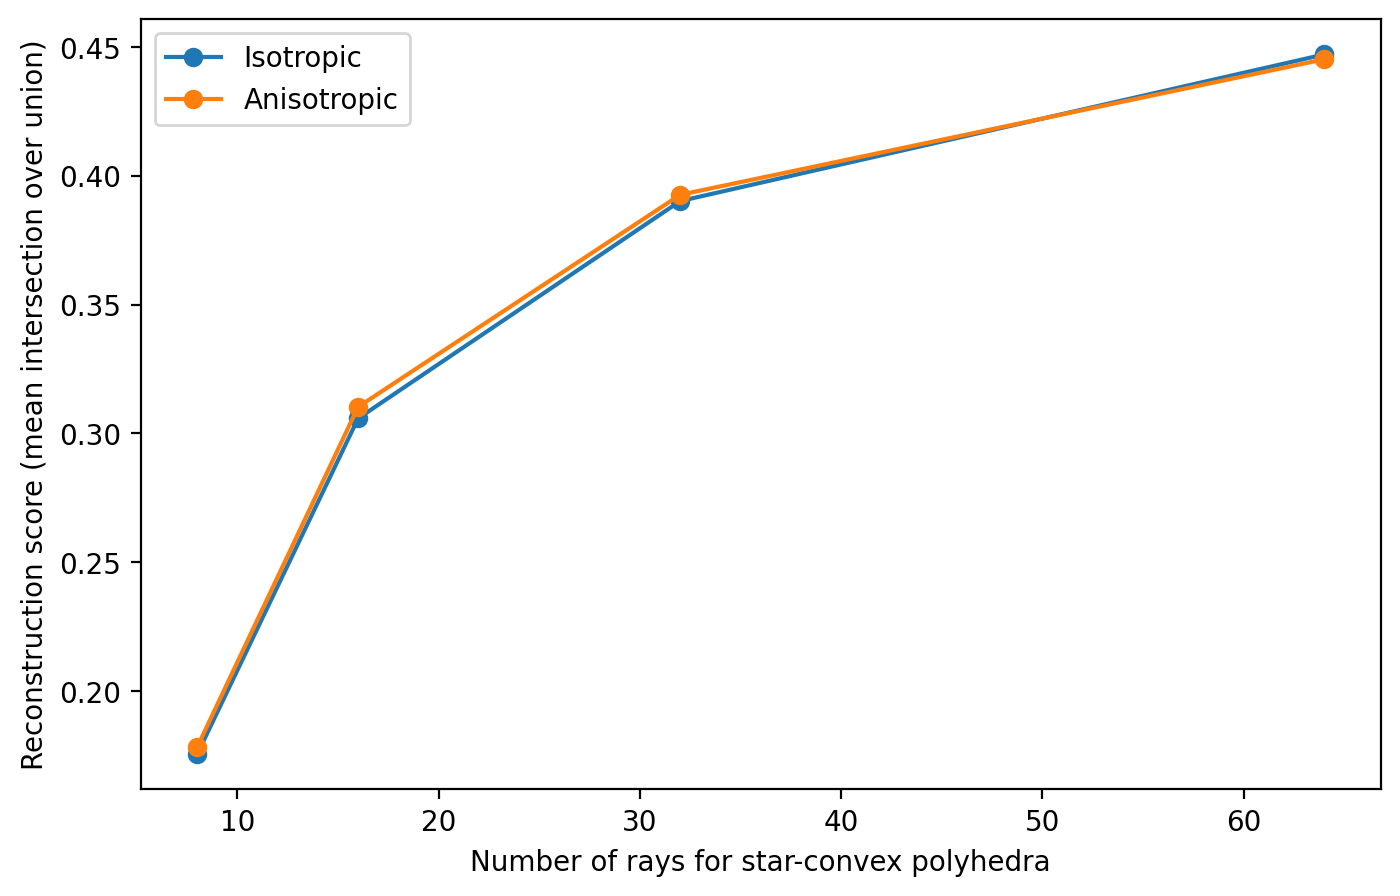

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(n_rays, scores_iso,   'o-', label='Isotropic')
plt.plot(n_rays, scores_aniso, 'o-', label='Anisotropic')
plt.xlabel('Number of rays for star-convex polyhedra')
plt.ylabel('Reconstruction score (mean intersection over union)')
plt.legend()
None;

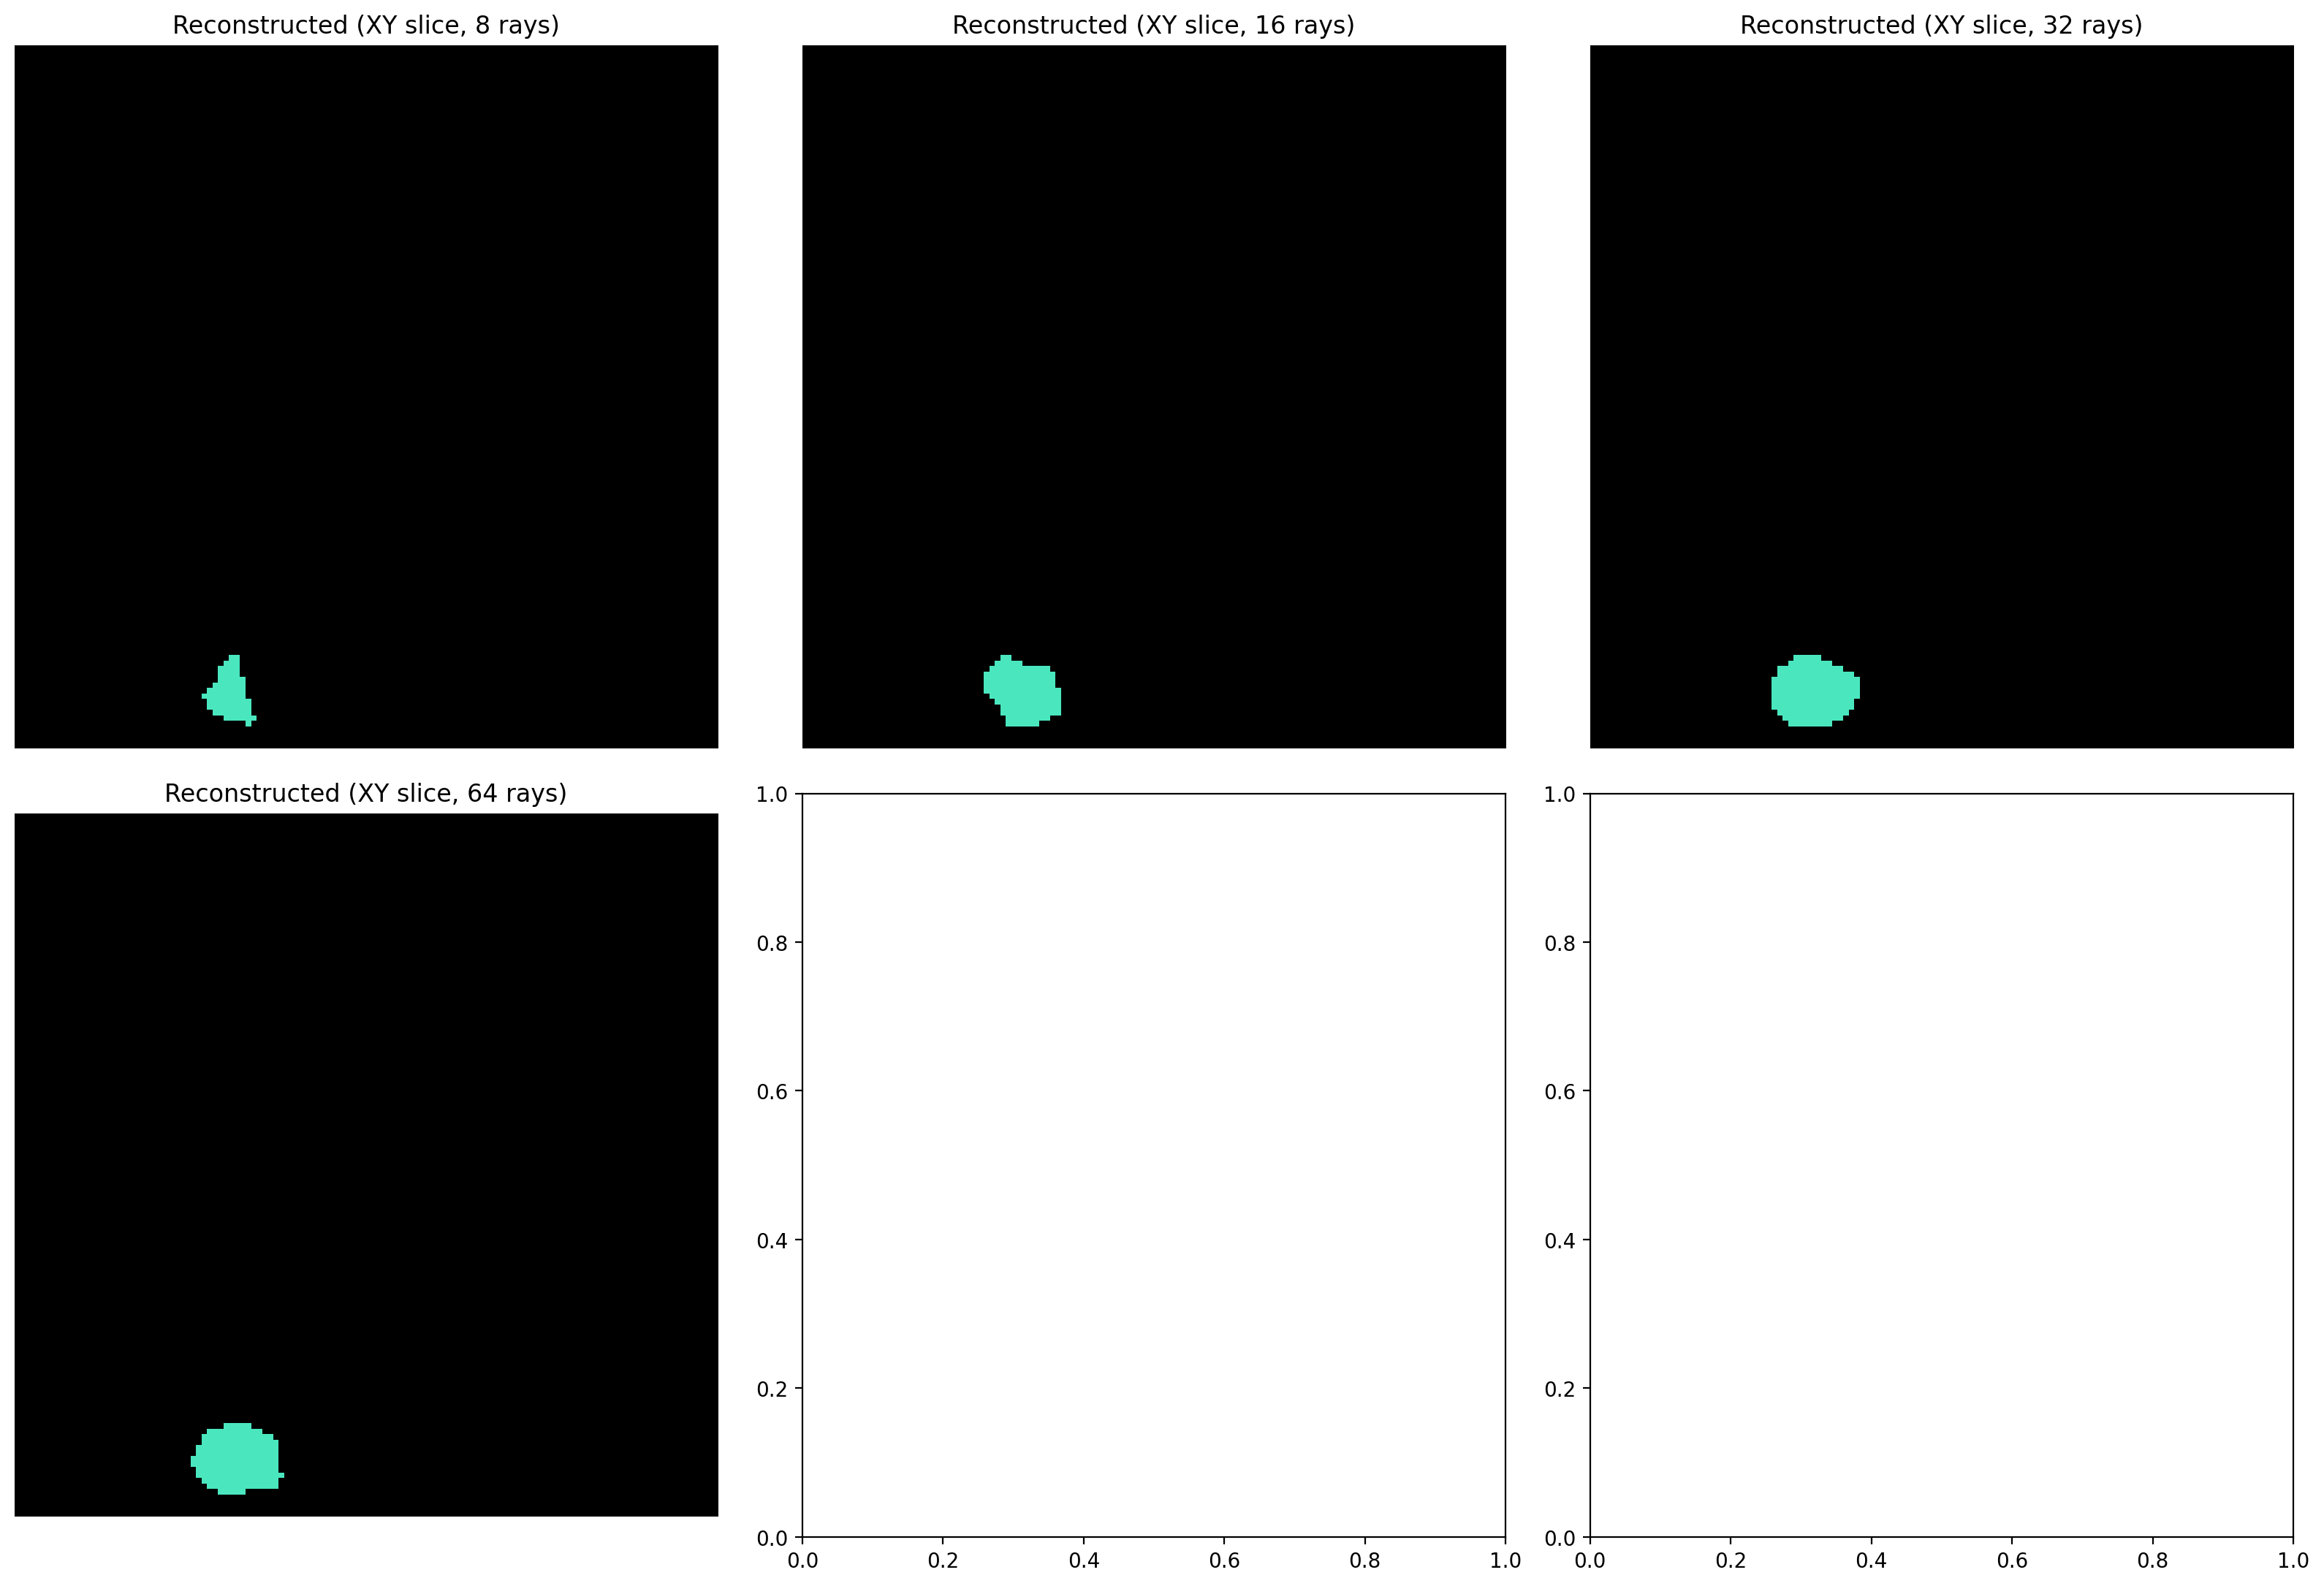

In [ ]:
fig, ax = plt.subplots(2,3, figsize=(16,11))
for a,r in zip(ax.flat,n_rays):
    z = lbl.shape[0] // 2
    rays = Rays_GoldenSpiral(r, anisotropy=None)
    a.imshow(relabel_image_stardist3D(lbl, rays)[z], cmap=lbl_cmap)
    a.set_title('Reconstructed (XY slice, %d rays)' % r)
    a.axis('off')
plt.tight_layout();

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

In [ ]:
n_channel = 1

In [ ]:
#Normalize input images and fill holes in masks
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
    sys.stdout.flush()

X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]
Y = [fill_label_holes(y) for y in tqdm(Y)]


100%|██████████| 80/80 [00:02<00:00, 28.33it/s]

100%|██████████| 80/80 [00:01<00:00, 60.89it/s]


In [ ]:
assert len(X) > 1, "not enough training data"
rng = np.random.RandomState(42)
ind = rng.permutation(len(X))
n_val = max(1, int(round(0.15 * len(ind))))
ind_train, ind_val = ind[:-n_val], ind[-n_val:]
X_val, Y_val = [X[i] for i in ind_val]  , [Y[i] for i in ind_val]
X_trn, Y_trn = [X[i] for i in ind_train], [Y[i] for i in ind_train]
print('number of images: %3d' % len(X))
print('- training:       %3d' % len(X_trn))
print('- validation:     %3d' % len(X_val))

number of images:  80
- training:        68
- validation:      12


In [ ]:
def plot_img_label(img, lbl, img_title="image (XY slice)", lbl_title="label (XY slice)", z=None, **kwargs):
    if z is None:
        z = img.shape[0] // 2
    fig, (ai,al) = plt.subplots(1,2, figsize=(12,5), gridspec_kw=dict(width_ratios=(1.25,1)))
    im = ai.imshow(img[z], cmap='gray', clim=(0,1))
    ai.set_title(img_title)
    fig.colorbar(im, ax=ai)
    al.imshow(lbl[z], cmap=lbl_cmap)
    al.set_title(lbl_title)
    plt.tight_layout()

In [ ]:
i = 0
img, lbl = X[i], Y[i]
assert img.ndim in (3,4)
img = img if img.ndim==3 else img[...,:3]
plot_img_label(img,lbl)
None;

In [ ]:
print(Config3D.__doc__)


Configuration for a :class:`StarDist3D` model.

    Parameters
    ----------
    axes : str or None
        Axes of the input images.
    rays : Rays_Base, int, or None
        Ray factory (e.g. Ray_GoldenSpiral).
        If an integer then Ray_GoldenSpiral(rays) will be used
    n_channel_in : int
        Number of channels of given input image (default: 1).
    grid : (int,int,int)
        Subsampling factors (must be powers of 2) for each of the axes.
        Model will predict on a subsampled grid for increased efficiency and larger field of view.
    n_classes : None or int
        Number of object classes to use for multi-class predection (use None to disable)
    anisotropy : (float,float,float)
        Anisotropy of objects along each of the axes.
        Use ``None`` to disable only for (nearly) isotropic objects shapes.
        Also see ``utils.calculate_extents``.
    backbone : str
        Name of the neural network architecture to be used as backbone.
    kwargs : dict
  

In [ ]:
extents = calculate_extents(Y)
anisotropy = tuple(np.max(extents) / extents)
print('empirical anisotropy of labeled objects = %s' % str(anisotropy))

empirical anisotropy of labeled objects = (1.087719298245614, 1.1923076923076923, 1.0)


In [ ]:
n_channel = 1

In [ ]:
# 32 is a good default choice (see 1_data.ipynb)
n_rays = 32

# Use OpenCL-based computations for data generator during training (requires 'gputools')
use_gpu = False and gputools_available()

# Predict on subsampled grid for increased efficiency and larger field of view
grid = tuple(1 if a > 1.5 else 2 for a in anisotropy)

# Use rays on a Fibonacci lattice adjusted for measured anisotropy of the training data
rays = Rays_GoldenSpiral(n_rays, anisotropy=anisotropy)

conf = Config3D (
    rays             = rays,
    grid             = grid,
    anisotropy       = anisotropy,
    use_gpu          = use_gpu,
    n_channel_in     = n_channel,
    # adjust for your data below (make patch size as large as possible)
    train_patch_size = (48,96,96),
    train_batch_size = 2,
)
print(conf)
vars(conf)

Config3D(n_dim=3, axes='ZYXC', n_channel_in=1, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2, 2), anisotropy=(1.087719298245614, 1.1923076923076923, 1.0), backbone='unet', rays_json={'name': 'Rays_GoldenSpiral', 'kwargs': {'n': 32, 'anisotropy': (1.087719298245614, 1.1923076923076923, 1.0)}}, n_classes=None, unet_n_depth=2, unet_kernel_size=(3, 3, 3), unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=(2, 2, 2), unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=(None, None, None, 1), net_mask_shape=(None, None, None, 1), train_patch_size=(48, 96, 96), train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=(1, 0.2), train_class_weights=(1, 1), train_epochs=400, train_steps_per_epoch=100, train_learning_r

{'n_dim': 3,
 'axes': 'ZYXC',
 'n_channel_in': 1,
 'n_channel_out': 33,
 'train_checkpoint': 'weights_best.h5',
 'train_checkpoint_last': 'weights_last.h5',
 'train_checkpoint_epoch': 'weights_now.h5',
 'n_rays': 32,
 'grid': (2, 2, 2),
 'anisotropy': (1.087719298245614, 1.1923076923076923, 1.0),
 'backbone': 'unet',
 'rays_json': {'name': 'Rays_GoldenSpiral',
  'kwargs': {'n': 32,
   'anisotropy': (1.087719298245614, 1.1923076923076923, 1.0)}},
 'n_classes': None,
 'unet_n_depth': 2,
 'unet_kernel_size': (3, 3, 3),
 'unet_n_filter_base': 32,
 'unet_n_conv_per_depth': 2,
 'unet_pool': (2, 2, 2),
 'unet_activation': 'relu',
 'unet_last_activation': 'relu',
 'unet_batch_norm': False,
 'unet_dropout': 0.0,
 'unet_prefix': '',
 'net_conv_after_unet': 128,
 'net_input_shape': (None, None, None, 1),
 'net_mask_shape': (None, None, None, 1),
 'train_patch_size': (48, 96, 96),
 'train_background_reg': 0.0001,
 'train_foreground_only': 0.9,
 'train_sample_cache': True,
 'train_dist_loss': 'mae'

In [ ]:
if use_gpu:
    from csbdeep.utils.tf import limit_gpu_memory
    # adjust as necessary: limit GPU memory to be used by TensorFlow to leave some to OpenCL-based computations
    limit_gpu_memory(0.8)
    # alternatively, try this:
    # limit_gpu_memory(None, allow_growth=True)

**Save the model finally.**

In [ ]:
model = StarDist3D(conf, name='stardist', basedir='/content/drive/MyDrive/stardist_model')


Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
median_size = calculate_extents(Y, np.median)
fov = np.array(model._axes_tile_overlap('ZYX'))
print(f"median object size:      {median_size}")
print(f"network field of view :  {fov}")
if any(median_size > fov):
    print("WARNING: median object size larger than field of view of the neural network.")

median object size:      [14.25 13.   15.5 ]
network field of view :  [46 46 46]


In [ ]:
def random_fliprot(img, mask, axis=None):
    if axis is None:
        axis = tuple(range(mask.ndim))
    axis = tuple(axis)

    assert img.ndim>=mask.ndim
    perm = tuple(np.random.permutation(axis))
    transpose_axis = np.arange(mask.ndim)
    for a, p in zip(axis, perm):
        transpose_axis[a] = p
    transpose_axis = tuple(transpose_axis)
    img = img.transpose(transpose_axis + tuple(range(mask.ndim, img.ndim)))
    mask = mask.transpose(transpose_axis)
    for ax in axis:
        if np.random.rand() > 0.5:
            img = np.flip(img, axis=ax)
            mask = np.flip(mask, axis=ax)
    return img, mask

def random_intensity_change(img):
    img = img*np.random.uniform(0.6,2) + np.random.uniform(-0.2,0.2)
    return img

def augmenter(x, y):
    """Augmentation of a single input/label image pair.
    x is an input image
    y is the corresponding ground-truth label image
    """
    # Note that we only use fliprots along axis=(1,2), i.e. the yx axis
    # as 3D microscopy acquisitions are usually not axially symmetric
    x, y = random_fliprot(x, y, axis=(1,2))
    x = random_intensity_change(x)
    return x, y

In [ ]:
# plot some augmented examples
img, lbl = X[0],Y[0]
plot_img_label(img, lbl)
for _ in range(3):
    img_aug, lbl_aug = augmenter(img,lbl)
    plot_img_label(img_aug, lbl_aug, img_title="image augmented (XY slice)", lbl_title="label augmented (XY slice)")

In [ ]:
quick_demo = True

if quick_demo:
    print (
        "NOTE: This is only for a quick demonstration!\n"
        "      Please set the variable 'quick_demo = False' for proper (long) training.",
        file=sys.stderr, flush=True
    )
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter,
                epochs=2, steps_per_epoch=5)

    print("====> Stopping training and loading previously trained demo model from disk.", file=sys.stderr, flush=True)
    model = StarDist3D.from_pretrained('3D_demo')
else:
    model.train(X_trn, Y_trn, validation_data=(X_val,Y_val), augmenter=augmenter)
None;

NOTE: This is only for a quick demonstration!
      Please set the variable 'quick_demo = False' for proper (long) training.


Epoch 1/2


  0%|          | 0/80 [05:20<?, ?it/s]
Cause: Unable to locate the source code of <function _gcd_import at 0x7863764f7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Cause: Unable to locate the source code of <function _gcd_import at 0x7863764f7400>. Note that functions defined in certain environments, like the interactive Python shell, do not expose their source code. If that is the case, you should define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.experimental.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
5/5 [==============================] - 16s 968ms/step - loss: 1.5168 - prob_loss: 0.5477 - dist_loss: 4.8457 - prob_kld: 0.5445 - dist_relevant_mae: 4.8457 - dist_relevant_mse: 36.2309 - dist_dist_iou_metric: 9.4755e-05 - val_loss: 1.2811 - val_prob_loss: 0.2066 - val_dist_loss: 5.3726 - val_prob_kld: 0.1850 - val_dist_relevant_mae: 5.3726 - val_dist_relevant_mse: 44.0736 - val_dist_dist_iou_metric: 0.0029 - lr: 3.0000e-04
Epoch 2/2
5/5 [==============================] - 2s 3

====> Stopping training and loading previously trained demo model from disk.


Found model '3D_demo' for 'StarDist3D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.707933, nms_thresh=0.3.


In [ ]:
if quick_demo:
    # only use a single validation image for demo
    model.optimize_thresholds(X_val[:1], Y_val[:1])
else:
    model.optimize_thresholds(X_val, Y_val)

NMS threshold = 0.5:  15%|█▌        | 3/20 [00:01<00:10,  1.66it/s, 0.772 -> 0.000]


Using optimized values: prob_thresh=0.386176, nms_thresh=0.3.


In [ ]:
Y_val_pred = [model.predict_instances(x, n_tiles=model._guess_n_tiles(x), show_tile_progress=False)[0]
              for x in tqdm(X_val)]

100%|██████████| 12/12 [04:31<00:00, 22.61s/it]


In [ ]:
plot_img_label(X_val[0],Y_val[0], lbl_title="label GT (XY slice)")
plot_img_label(X_val[0],Y_val_pred[0], lbl_title="label Pred (XY slice)")

In [ ]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
stats = [matching_dataset(Y_val, Y_val_pred, thresh=t, show_progress=False) for t in tqdm(taus)]

100%|██████████| 9/9 [00:05<00:00,  1.51it/s]


In [ ]:
stats[taus.index(0.7)]


DatasetMatching(criterion='iou', thresh=0.7, fp=1975, tp=0, fn=164, precision=0, recall=0, accuracy=0, f1=0, n_true=164, n_pred=1975, mean_true_score=0.0, mean_matched_score=0.0, panoptic_quality=0.0, by_image=False)

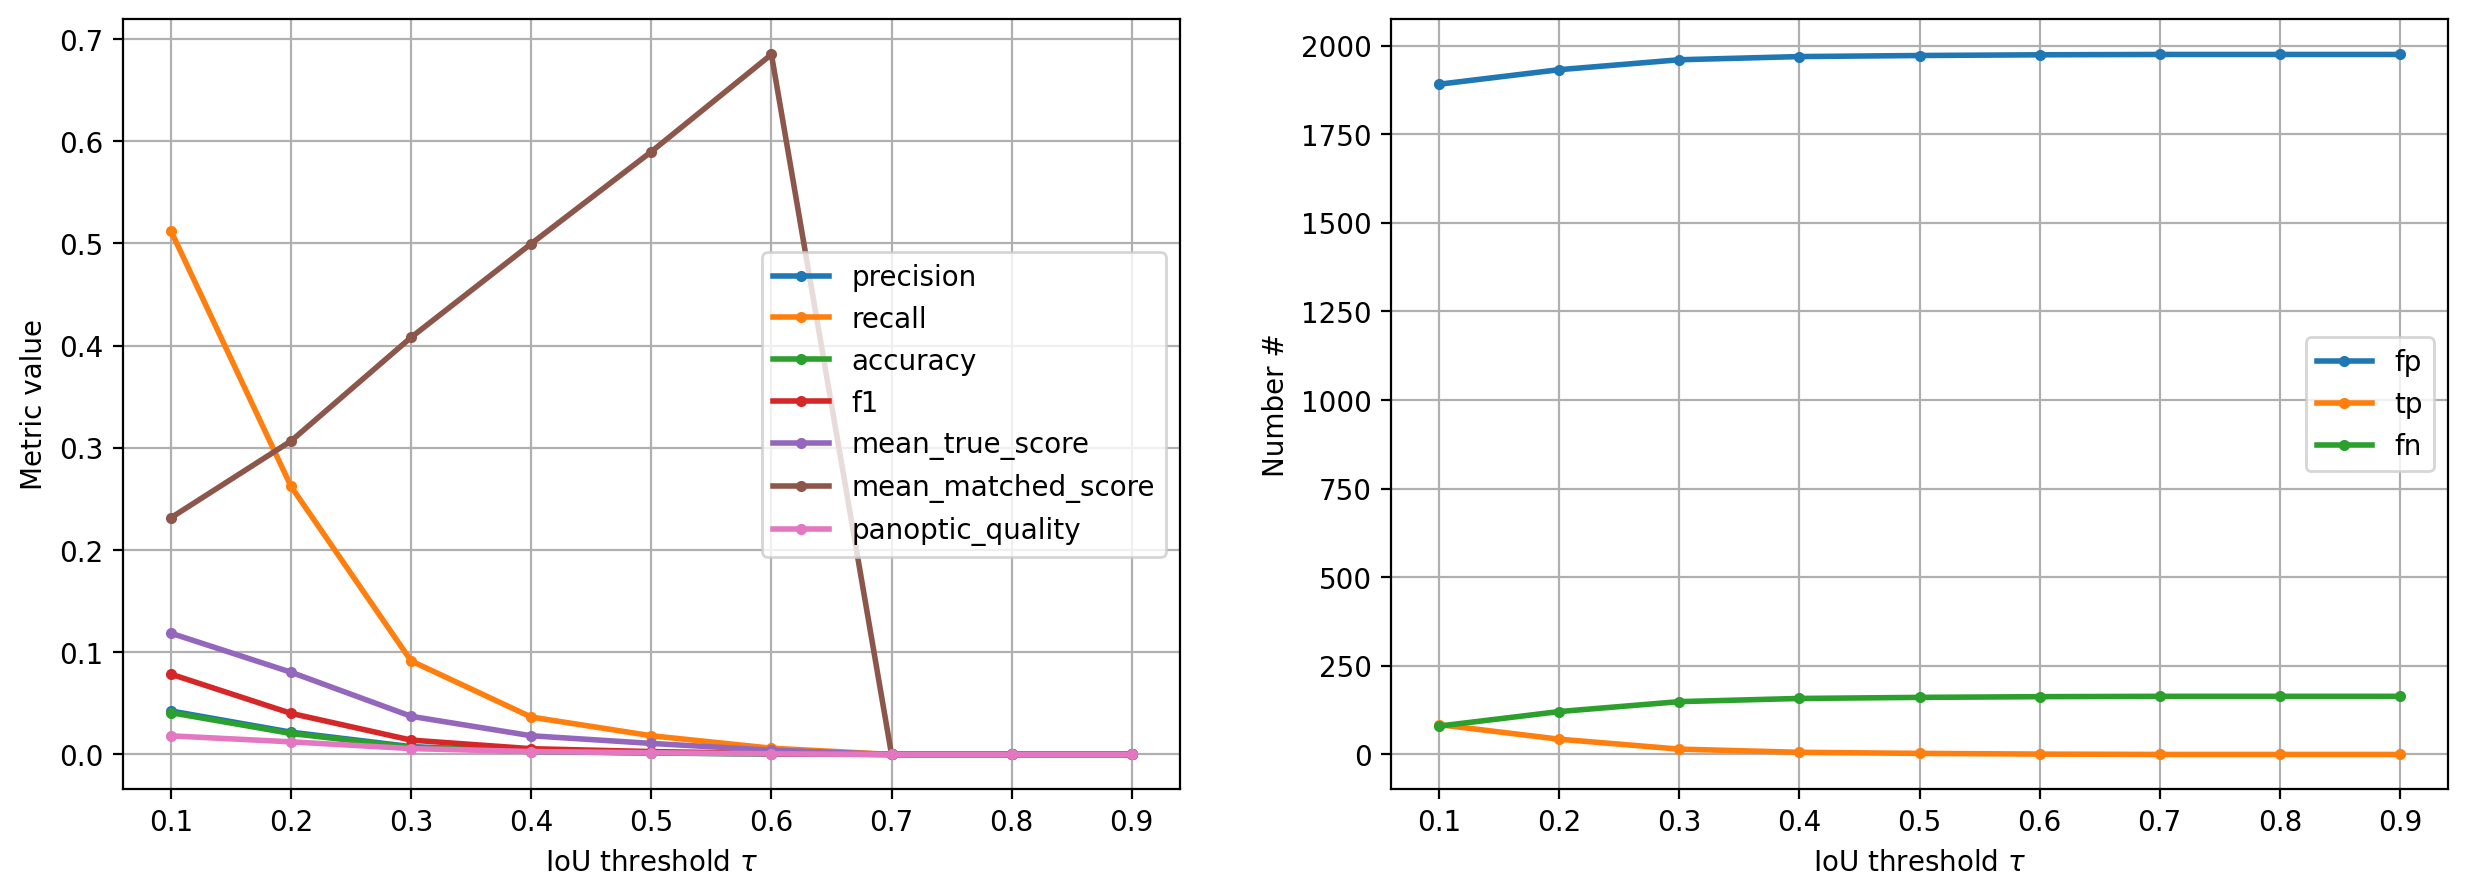

In [ ]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

**Do the predictions finally. Images of any sizes could be used. **

In [ ]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = 'none'
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tifffile import imread
from csbdeep.utils import Path, normalize
from csbdeep.io import save_tiff_imagej_compatible

from stardist import random_label_cmap
from stardist.models import StarDist3D

np.random.seed(6)
lbl_cmap = random_label_cmap()

In [ ]:
T = sorted(glob('/content/drive/MyDrive/stardist_predict_inputs/*.tif'))


In [ ]:
T = list(map(io.imread,T))


In [ ]:
n_channel = 1 if X[0].ndim == 3 else X[0].shape[-1]
axis_norm = (0,1,2)   # normalize channels independently
# axis_norm = (0,1,2,3) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))

In [ ]:
T[0].shape


(68, 128, 128)

In [ ]:
#Define the number of channels and normalize images with independendt channels or jointly
n_channel = 1 if X[0].ndim == 2 else X[0].shape[-1]
axis_norm = (0,1)   # normalize channels independently
# axis_norm = (0,1,2) # normalize channels jointly
if n_channel > 1:
    print("Normalizing image channels %s." % ('jointly' if axis_norm is None or 2 in axis_norm else 'independently'))
X = [normalize(x,1,99.8,axis=axis_norm) for x in tqdm(X)]



Normalizing image channels independently.


100%|██████████| 80/80 [00:04<00:00, 17.82it/s]


In [ ]:
fig, ax = plt.subplots(7,8, figsize=(16,16))
for i,(a,x) in enumerate(zip(ax.flat, X)):
  a.imshow(x if x.ndim==2 else x[...,0], cmap='gray')
  a.set_title(i)
  [a.axis('off') for a in ax.flat]
  plt.tight_layout()

In [ ]:
model = StarDist3D(None, name='stardist', basedir='/content/drive/MyDrive/stardist_model')


Loading network weights from 'weights_best.h5'.
Couldn't load thresholds from 'thresholds.json', using default values. (Call 'optimize_thresholds' to change that.)
Using default values: prob_thresh=0.5, nms_thresh=0.4.


In [ ]:
from random import randint


In [ ]:
img_num = randint(0, len(T)-1)
img = T[img_num]
#img = normalize(X[16], 1,99.8, axis=axis_norm)
labels, details = model.predict_instances(img)


base.py (395): Predicting on non-float input... ( forgot to normalize? )


In [ ]:
io.imshow(T[0][12,:,:])